In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

plotpar = {'axes.labelsize': 30,
                  'font.size': 22,
                  'legend.fontsize': 15,
                  'xtick.labelsize': 30,
                  'ytick.labelsize': 30,
                  'text.usetex': True}
plt.rcParams.update(plotpar)

In [3]:
df = pd.read_csv("../data/twins.csv")

In [7]:
def r_prime_hk_from_sindex_and_teff(sindex, teff, mh):
    log_C_cf = - 7.31 + 2.25e-3 * teff - 1.70e-7 * teff**2
    log_r_phot = - 4.78845 - (3.70700 / (1. + (teff/4598.92)**17.5272))
    log_r_hk = np.log10(1.34e-4 * 10**log_C_cf * sindex)
    return log_r_hk + 0.5 * mh 

rhk = r_prime_hk_from_sindex_and_teff(df["<S>"].values, df.Teff.values, df["[M/H]"].values)

In [8]:
mass = df.M_iso.values
age, age_err = np.log(df["Age_iso"].values), df["Age_err"].values/df["Age_iso"].values

In [9]:
with pm.Model() as model:
        
    # Parameters to infer.
    rhk_break = pm.Normal("rhk_break", mu=-4.5, sigma=.1)                         # the break in age
    b = pm.Normal("b", mu=-4, sd=5)                                            # The constant term
    log_smooth = pm.Normal("log_smooth", mu=np.log(1), sigma=10.0)          # The smoothness of the break. (lower is smoother)
    smooth = tt.exp(log_smooth)
    slope_low = pm.Normal("slope_low", mu=0.0, sd=10.0)                        # The slope below the break
    slope_high = pm.Normal("slope_high", mu=0.0, sd=10.0)                      # The slope above the break
    
    # Mean model
    def get_mean_model(rhk):
        """
        Predict the age at given values of mass and log(age).
        Use a smoothed broken power law for the age - mass relation.
        Use get_rhk_mass for the R'HK-mass relation.
        """
        delta = rhk - rhk_break
        slope = slope_low / (1 + tt.exp(smooth * delta)) + slope_high / (1 + tt.exp(-smooth * delta))
        return slope * delta + b
    
    mean_model = get_mean_model(rhk)
    pm.Deterministic("mean_model", mean_model)
    
    # Likelihood
    pm.Normal("obs", mu=mean_model, sigma=age_err, observed=age)
        
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [slope_low, slope_high])
    map_soln = xo.optimize(map_soln, [log_smooth])
    map_soln = xo.optimize(map_soln, [rhk_break, b])
    map_soln = xo.optimize(map_soln, [slope_low, slope_high, log_smooth])
    map_soln = xo.optimize(map_soln, [slope_high, slope_low, log_smooth, b, rhk_break])
    
    print("done")

optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -468724.5480624304 -> -10903.280229026095


optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -10903.280229026095 -> -10900.865973084052


optimizing logp for variables: [b, rhk_break]


message: Desired error not necessarily achieved due to precision loss.
logp: -10900.865973084052 -> -5899.601799848312


optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -5899.601799848312 -> -3774.0545957235286


optimizing logp for variables: [rhk_break, b, log_smooth, slope_low, slope_high]



done


message: Optimization terminated successfully.
logp: -3774.0545957235286 -> -209.71421926334372


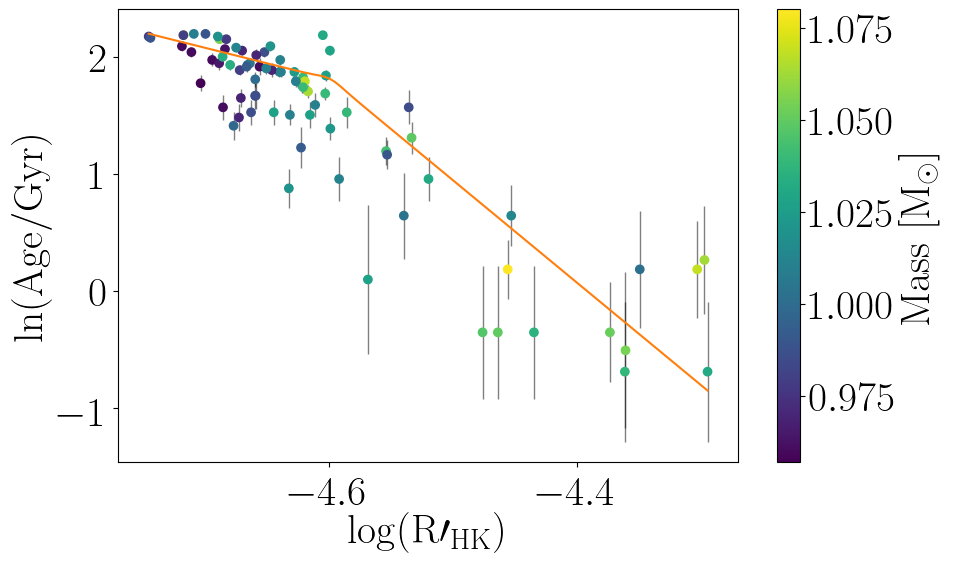

In [18]:
# Mean model
def broken_power_law(rhk):
    smooth = np.exp(map_soln["log_smooth"])
    delta = rhk - map_soln["rhk_break"]
    slope = map_soln["slope_low"] / (1 + np.exp(smooth * delta)) + map_soln["slope_high"] / (1 + np.exp(-smooth * delta))
    return slope * delta + map_soln["b"]

plt.figure(figsize=(10, 6), dpi=100)
rhks = np.linspace(min(rhk), max(rhk), 100)
plt.errorbar(rhk, age, yerr=age_err, fmt="k.", lw=1, alpha=.5, zorder=0)
plt.scatter(rhk, age, c=mass, zorder=1)
plt.plot(rhks, broken_power_law(rhks), "C1")
plt.colorbar(label="$\mathrm{Mass~[M_\odot]}$")
plt.xlabel("$\mathrm{\log(R\prime_{HK})}$")
plt.ylabel("$\mathrm{\ln(Age/Gyr)}$");

In [20]:
with pm.Model() as model1:
        
    # Parameters to infer.
    rhk_break = pm.Normal("rhk_break", mu=-4.5, sigma=.1)                         # the break in age
    b = pm.Normal("b", mu=-4, sd=5)                                            # The constant term
    m = pm.Normal("m", mu=0, sd=5)                                            # The constant term
    log_smooth = pm.Normal("log_smooth", mu=np.log(1), sigma=10.0)          # The smoothness of the break. (lower is smoother)
    smooth = tt.exp(log_smooth)
    slope_low = pm.Normal("slope_low", mu=0.0, sd=10.0)                        # The slope below the break
    slope_high = pm.Normal("slope_high", mu=0.0, sd=10.0)                      # The slope above the break
    
    # Mass model
    def mass_model(mass):
        return m * mass + b
    
    # Mean model
    def get_mean_model(rhk, mass):
        """
        Predict the age at given values of mass and log(age).
        Use a smoothed broken power law for the age - mass relation.
        Use get_rhk_mass for the R'HK-mass relation.
        """
        delta = rhk - rhk_break
        slope = slope_low / (1 + tt.exp(smooth * delta)) + slope_high / (1 + tt.exp(-smooth * delta))
        return slope * delta + mass_model(mass)
    
    mean_model = get_mean_model(rhk, mass)
    pm.Deterministic("mean_model", mean_model)
    
    # Likelihood
    pm.Normal("obs", mu=mean_model, sigma=age_err, observed=age)
        
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [slope_low, slope_high])
    map_soln = xo.optimize(map_soln, [log_smooth])
    map_soln = xo.optimize(map_soln, [rhk_break, m, b])
    map_soln = xo.optimize(map_soln, [slope_low, slope_high, log_smooth])
    map_soln = xo.optimize(map_soln, [slope_high, slope_low, log_smooth, m, b, rhk_break])
    
    print("done")

optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -468727.07643887604 -> -10905.808605471733


optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -10905.808605471733 -> -10903.39434952969


optimizing logp for variables: [b, m, rhk_break]


message: Desired error not necessarily achieved due to precision loss.
logp: -10903.39434952969 -> -5895.580912809263


optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Desired error not necessarily achieved due to precision loss.
logp: -5895.580912809263 -> -3761.2105485556435


optimizing logp for variables: [rhk_break, b, m, log_smooth, slope_low, slope_high]



done


message: Optimization terminated successfully.
logp: -3761.2105485556435 -> -201.92644633129862


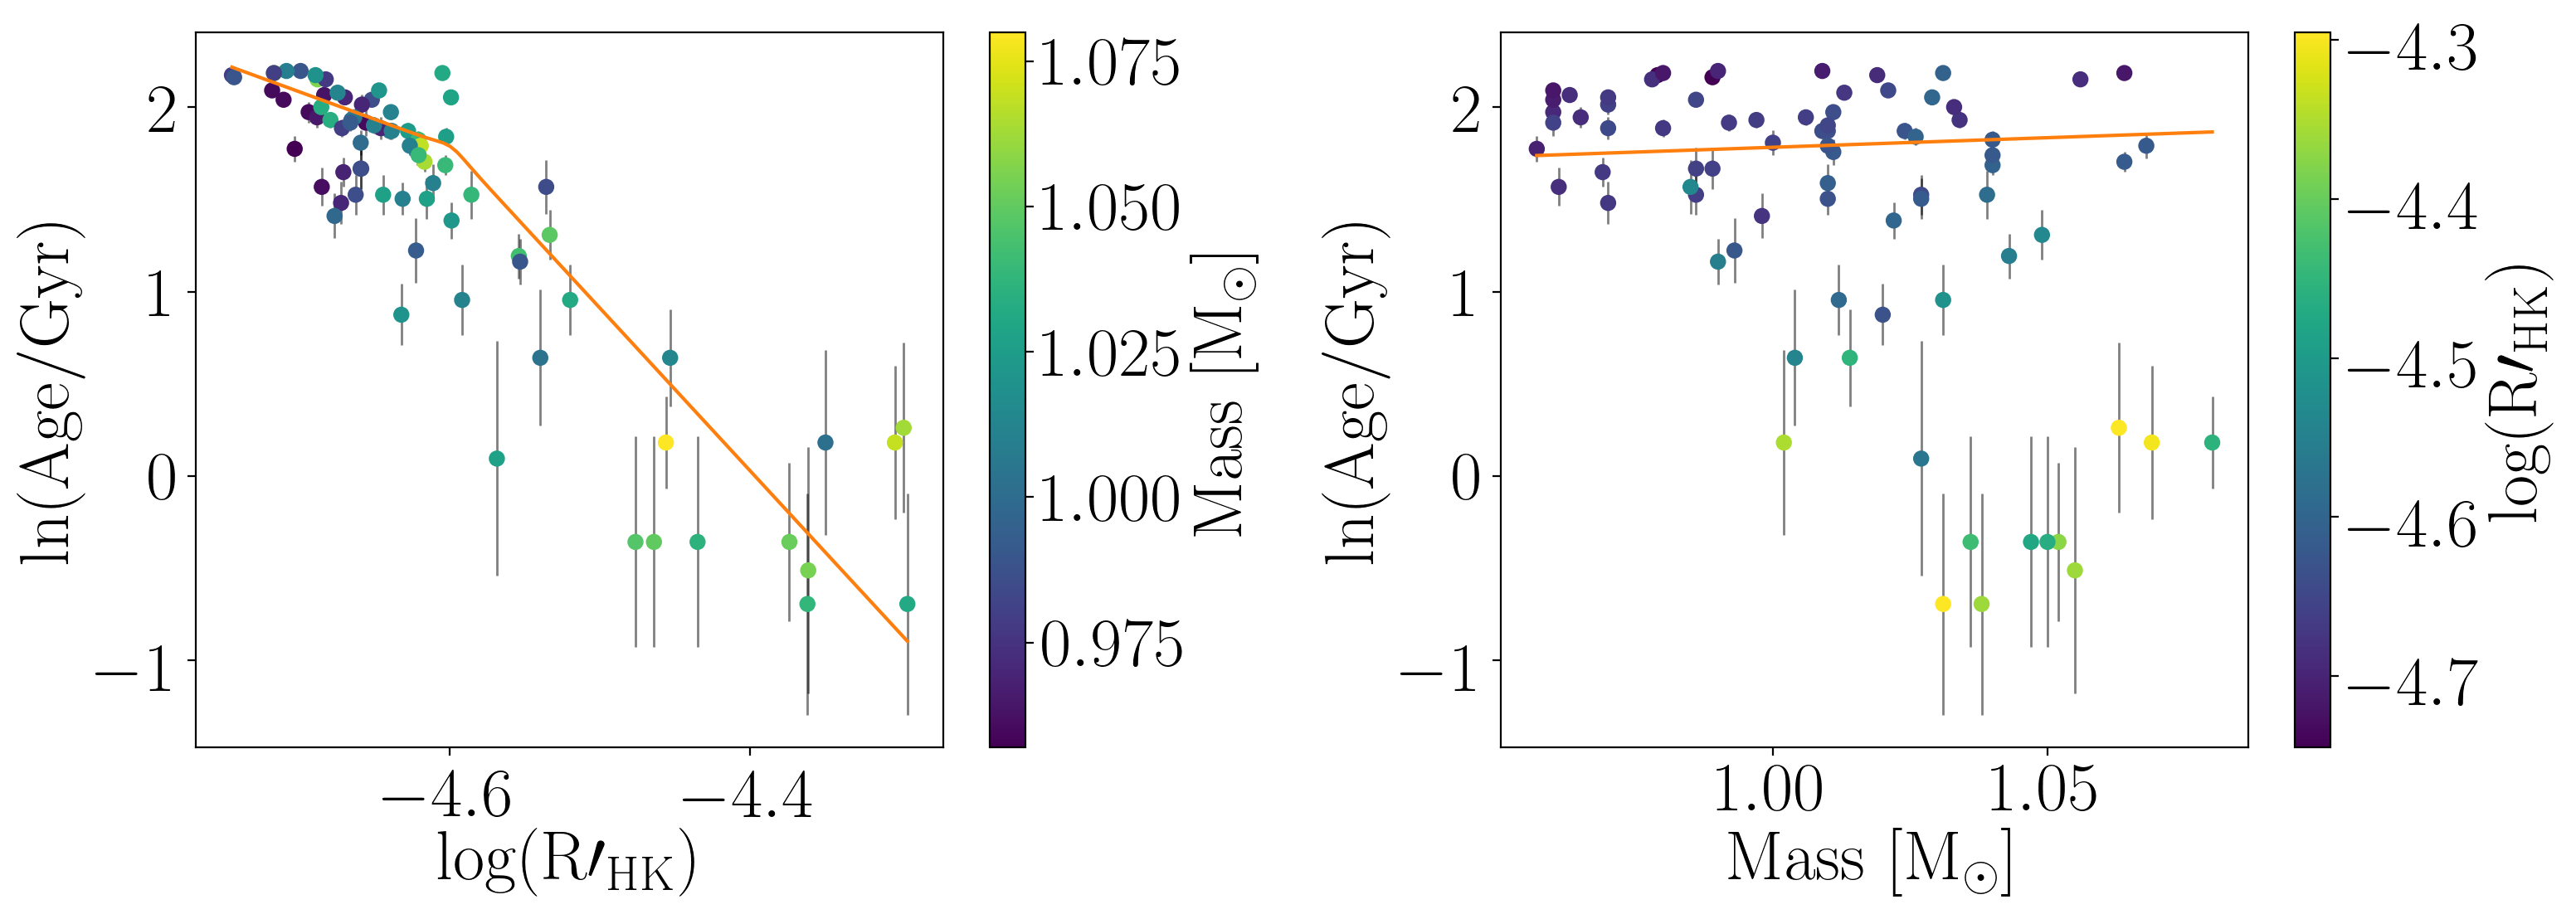

In [36]:
def mass_model1(mass):
    return map_soln["m"] * mass + map_soln["b"]
    
def broken_power_law1(rhk, mass):
    smooth = np.exp(map_soln["log_smooth"])
    delta = rhk - map_soln["rhk_break"]
    slope = map_soln["slope_low"] / (1 + np.exp(smooth * delta)) + map_soln["slope_high"] / (1 + np.exp(-smooth * delta))
    return slope * delta + mass_model1(mass) #map_soln["b"]

rhks = np.linspace(min(rhk), max(rhk), 100)
masses = np.linspace(min(mass), max(mass), 100)

fig = plt.figure(figsize=(16, 6), dpi=200)

ax0 = fig.add_subplot(121)
ax0.errorbar(rhk, age, yerr=age_err, fmt="k.", lw=1, alpha=.5, zorder=0)
cb = ax0.scatter(rhk, age, c=mass, zorder=1)
ax0.plot(rhks, broken_power_law1(rhks, 1.), "C1")
plt.colorbar(cb, label="$\mathrm{Mass~[M_\odot]}$")
ax0.set_xlabel("$\mathrm{\log(R\prime_{HK})}$")
ax0.set_ylabel("$\mathrm{\ln(Age/Gyr)}$");

ax1 = fig.add_subplot(122)
ax1.errorbar(mass, age, yerr=age_err, fmt="k.", lw=1, alpha=.5, zorder=0)
cb = ax1.scatter(mass, age, c=rhk, zorder=1)
plt.colorbar(cb, label="$\mathrm{\log(R\prime_{HK})}$")
ax1.set_xlabel("$\mathrm{Mass~[M_\odot]}$")
ax1.set_ylabel("$\mathrm{\ln(Age/Gyr)}$");
ax1.plot(masses, mass_model1(masses), "C1")


plt.tight_layout()